In [2]:
# Template for weird data space model fitting with Stan
# Example: fitting "SPI-light" data to a model of background sky
import numpy as np
import matplotlib.pyplot as plt
import stan_utility
import pystan
import pickle
import sys
from IPython.display import Image
#plt.style.use('thomas')

<h3>"SPI-light" is a hypothetical instrument with two detectors which are block from the source light alternatingly for each pointing.<br>
    The background is (chosen) to be uniform.<br>
    A sketch of the setup is shown below.</h3>

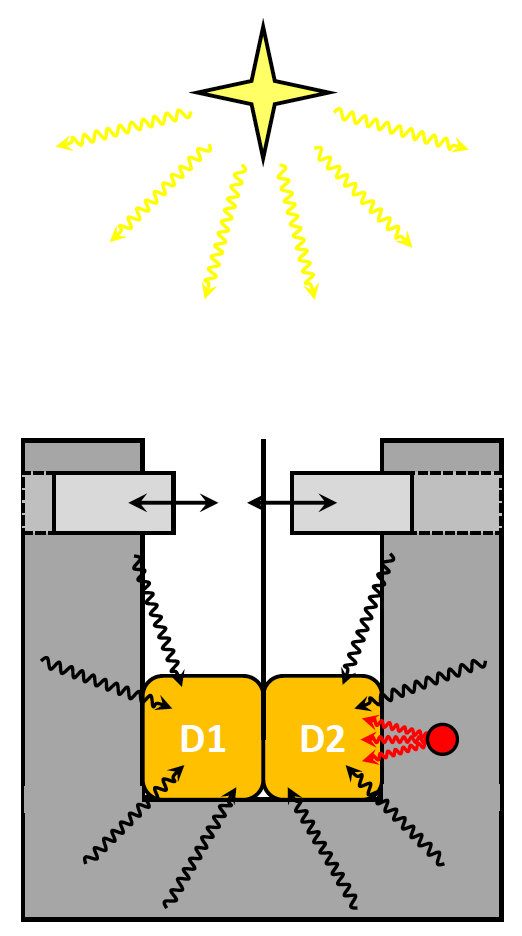

In [3]:
#plt.figure(figsize=(8,16))
with open('SPIlight.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h5>Background response</h5>

In [4]:
def R_BG(p): # pointing p
    return np.repeat(np.array([1.,1.]),len(p)).reshape(2,len(p)).T

<h5>Sky response</h5>

In [5]:
def R_SKY(p): # pointing p
    A_eff = 10.
    T_p = 100.
    return A_eff*T_p*np.array([1+(-1)**(p+1),1+(-1)**(p)]).T

<h5>Note the difference between background and sky response is that the R_BG is independent of p</h5>

<h5>We define 10 observation pointings 0..9</h5>

In [6]:
Np = 10
p = np.arange(Np)

<h5>What do the responses look like?</h5>

In [7]:
R_SKY(p).shape,R_BG(p).shape

((10, 2), (10, 2))

<h5>10 values for each of the 2 detectors</h5>

<h5>Define a plotting function for this type of data:</h5>

In [8]:
def SPIl_plot(p,
              y,color='black',label=None,
              y2=None,color2='red',label2=None,
              y3=None,color3='red',label3=None):
    pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting
    plt.step(pp,y.ravel(),color=color,label=label,where='mid')
    if np.any(y2 != None):
        plt.step(pp,y2.ravel(),color=color2,label=label2,where='mid')
    if np.any(y3 != None):
        plt.step(pp,y3.ravel(),color=color3,label=label3,where='mid')
    for i in range(len(p)+1):
        plt.axvline(i-0.5,linestyle='--',color='black')
    plt.xlabel('Pointing number')
    plt.ylabel('Counts')
    plt.legend()

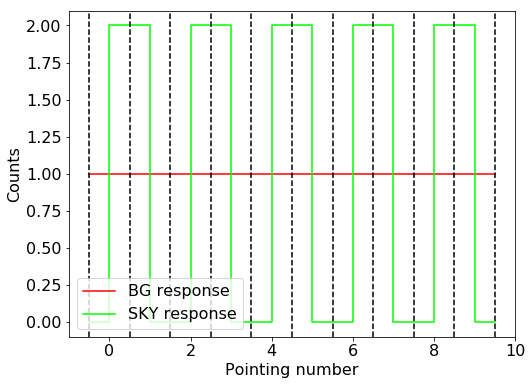

In [9]:
SPIl_plot(p,
          R_BG(p)/np.mean(R_BG(p)),color='red',label='BG response',
          y2=R_SKY(p)/np.mean(R_SKY(p)),color2='lime',label2='SKY response')

<h5>Here, each pair of vertical lines defines one pointing in which the background response (red) predicts 1 count in each detector.<br>
    The sky response predicts either 0 and 2 in a pointing (even numbered) or 2 and 0 (odd numbered).</h5>

<h5>Now create data</h5>

In [10]:
true_sky = 1e-3
true_bg = 30.

y_true = true_sky*R_SKY(p) + true_bg*R_BG(p)
yp = np.random.poisson(y_true)

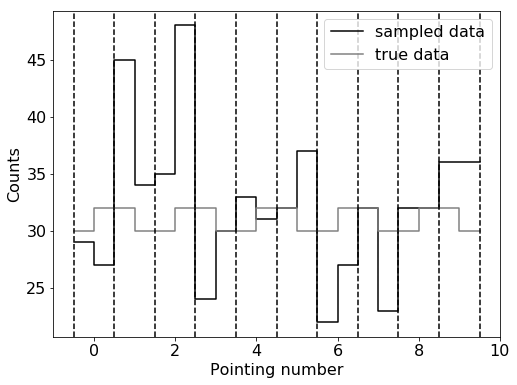

In [11]:
SPIl_plot(p,
          yp,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data')

In [12]:
"""## compile model (if not yet compiled):
model = pystan.StanModel('spimodfit.stan')

## save it to the file 'filename.pkl' for later use
with open('spimodfit.pkl', 'wb') as f:
    pickle.dump(model, f)"""
    
#read filename.pkl (if already compiled)
model = pickle.load(open('spimodfit.pkl', 'rb'))

<h5>We used python functions to create the data, now we use our known responses to input to the fit:</h5>

<h5>For our background model to work, we have to identify and transfer change points (if any). This is done by the following function (details later).</h5>

In [13]:
def make_bg_cuts(cuts,Np):
    cuts = [1] + cuts + [1e99]
    cuts = list(np.unique(cuts))
    bg_cuts = np.zeros(Np)
    cidx = 0
    for i in range(1,Np+1):
        #print(i)
        if (cuts[cidx] <= i < cuts[cidx+1]):
            bg_cuts[i-1] = cuts[cidx]
        else:
            cidx += 1
            bg_cuts[i-1] = cuts[cidx]
            
    Ncuts = len(np.unique(bg_cuts))
    idx_arr = np.ones(Np)
    for i in range(Ncuts):
        idx_arr[np.where(bg_cuts == cuts[i])[0]] = i+1
    
    return bg_cuts.astype(int), idx_arr.astype(int), Ncuts

<h5>Two examples for comprehension:</h5>

In [14]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],10) # for 10 pointings, use only one time node (== constant BG)
# (python's first index is zero, Stan's is 1 (!))

In [15]:
bg_cuts,idx_arr,Ncuts

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 1)

In [16]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([3,8],10) # for 10 pointings, use three time nodes at 1,3,8
bg_cuts,idx_arr,Ncuts

(array([1, 1, 3, 3, 3, 3, 3, 8, 8, 8]),
 array([1, 1, 2, 2, 2, 2, 2, 3, 3, 3]),
 3)

In [17]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [18]:
import time

<h5>Now, let's only optimise the posterior and plot the result:</h5>

In [19]:
init = {}
init['flux'] = np.array([1e-3])
init['Abg'] = np.repeat(30,Ncuts)
start = time.time()
op = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)
op

0.0014078617095947266


OrderedDict([('par',
              OrderedDict([('flux', array(0.00115206)),
                           ('Abg', array(31.09606706)),
                           ('model_values',
                            array([31.09606706, 33.40018293, 33.40018293, 31.09606706, 31.09606706,
                                   33.40018293, 33.40018293, 31.09606706, 31.09606706, 33.40018293,
                                   33.40018293, 31.09606706, 31.09606706, 33.40018293, 33.40018293,
                                   31.09606706, 31.09606706, 33.40018293, 33.40018293, 31.09606706])),
                           ('ppc',
                            array([32., 34., 44., 33., 41., 31., 43., 28., 34., 38., 25., 33., 22.,
                                   35., 29., 36., 31., 27., 37., 31.])),
                           ('model_tot',
                            array([64.49624999, 64.49624999, 64.49624999, 64.49624999, 64.49624999,
                                   64.49624999, 64.49624999, 64.4962499

<h5>The result dictionary (op) includes all the information that we generated in the Stan model.<br>
    The PPC and posterior models don't make much sence without the posterior distributions, but we get a value for the flux and the background amplitude (again, without uncertainties):</h5>

In [20]:
fitted_model = op['par']['model_values'].reshape((Np,Nrsp))

In [21]:
fitted_model.shape

(10, 2)

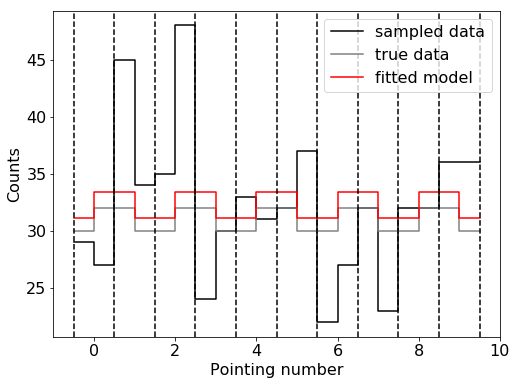

In [22]:
SPIl_plot(p,
          yp,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data',
          y3=fitted_model,color3='red',label3='fitted model')

<h5>Magic? Let's check out the sampling:</h5>

In [23]:
op2 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg']

In [24]:
op2

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]          1.5e-3  4.1e-5 9.9e-4 6.0e-5 7.4e-4 1.4e-3 2.2e-3 3.8e-3    598    1.0
Abg[1]            30.82    0.06   1.56   27.8  29.73  30.84  31.89  33.88    733    1.0
model_values[1]   30.82    0.06   1.56   27.8  29.73  30.84  31.89  33.88    733    1.0
model_values[2]   33.85    0.04   1.67  30.84  32.72  33.84  34.92  37.28   1472    1.0
model_values[3]   33.85    0.04   1.67  30.84  32.72  33.84  34.92  37.28   1472    1.0
model_values[4]   30.82    0.06   1.56   27.8  29.73  30.84  31.89  33.88    733    1.0
model_values[5]   30.82    0.06   1.56   27.8  29.73  30.84  31.89  33.88    733    1.0
model_values[6]   33.85    0.04   1.67  30.84  32.72  33.84  34.92  37.28   1472    1.0
model_values[7]   3

<h5>This is a lot of information.<br>
    Let's walk through this:<br>
    flux[1] and Abg[1] are our parameters of interest with fitted (mean or median (= 50% percentile)) value and uncertainty (e.g. standard deviation of the posterior distribution (sd) or whatever percentile you like).<br>
    model_values[1..20] are the fitted model values for each data point (!) with their respective uncertainties from the fitted parameters, their uncertainties, and the data.<br>
    ppc[1..20] are the posterior predictive values (= new data drawn from the model values) for each data points.<br>
    model_tot[1..10] are the total model counts, summed over the data space bins (here 2 detectors), i.e. the total number of photons per pointing.<br>
    model_bg[1..10] and model_sky[1..10] are the same as model_tot[1..0] but split into the individual model components.<br>
    Finally, lp__ is the log-posterior of the fit.</h5>

<h5>What do our posterior distributions for flux and Abg look like?</h5>

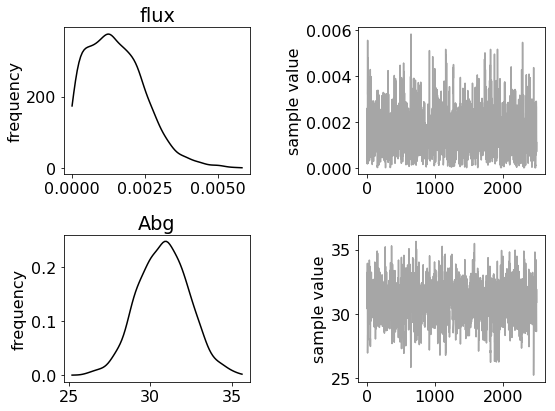

In [25]:
op2.plot(['flux','Abg']);
plt.tight_layout()

<h5>Clearly, our sky signal is not very "significant" (why?)</h5>

<h5>PPCs of complete data set (all data points):</h5>

In [26]:
pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting

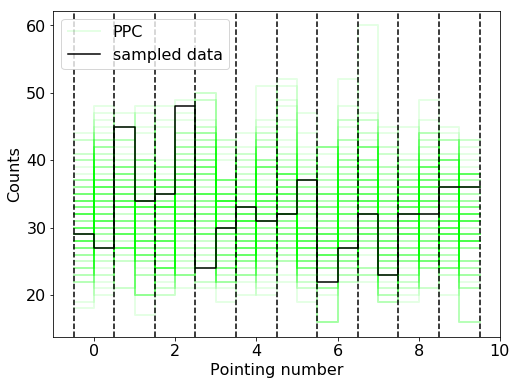

In [27]:
for i in range(0,2500,25):
    plt.step(pp,op2['ppc'][i,:],
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(pp,op2['ppc'][i,:],alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC in only time domain></h5>

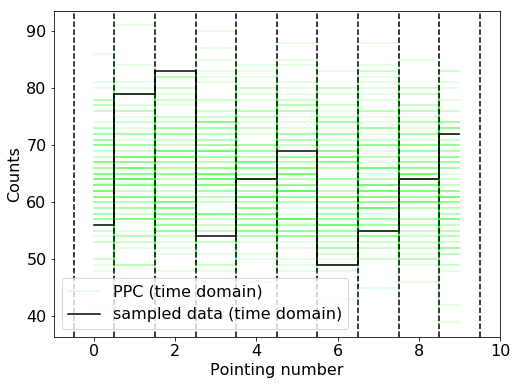

In [28]:
for i in range(0,2500,25):
    plt.step(p,np.sum(op2['ppc'][i,:].reshape((Np,Nrsp)),axis=1),
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(p,np.sum(op2['ppc'][i,:].reshape((Np,Nrsp)),axis=1),alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC (time domain)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data (time domain)',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend()

<h5>Model posterior (all data points)<br>
    (Do you understand the difference?)</h5>

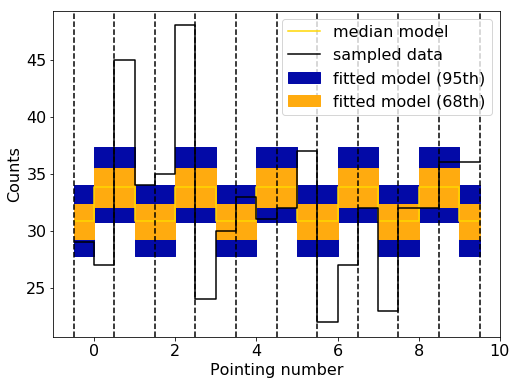

In [29]:

plt.step(pp,np.percentile(op2['model_values'],50,axis=0),color='gold',where='mid',label='median model')

plt.fill_between(pp,
         np.percentile(op2['model_values'],50-95.4/2,axis=0),
         np.percentile(op2['model_values'],50+95.4/2,axis=0),
                 step='mid',color='xkcd:cobalt blue',alpha=1.0,label='fitted model (95th)')

plt.fill_between(pp,
         np.percentile(op2['model_values'],50-68.3/2,axis=0),
         np.percentile(op2['model_values'],50+68.3/2,axis=0),
                 step='mid',color='xkcd:yellowish orange',alpha=1.0,label='fitted model (68th)')


SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>Model posterior (individual components, only time domain):</h5>

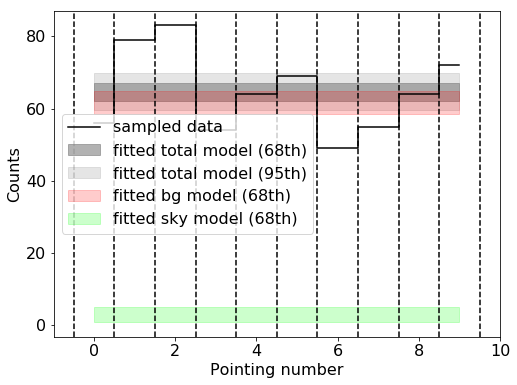

In [30]:

plt.fill_between(p,
         np.percentile(op2['model_tot'],50-68.3/2,axis=0),
         np.percentile(op2['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_tot'],50-95.4/2,axis=0),
         np.percentile(op2['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op2['model_bg'],50-68.3/2,axis=0),
         np.percentile(op2['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op2['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=6)

<h5>Example with scaling every pointing:</h5>

In [31]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts([1,6],Np)
bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(0,Np,1)+1),Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [32]:
op3 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg'])

In [33]:
op3

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]          1.4e-3  2.3e-5 9.4e-4 8.6e-5 7.2e-4 1.3e-3 2.1e-3 3.5e-3   1679    1.0
Abg[1]            27.39    0.07   3.78  20.29  24.67  27.31  29.99  35.04   2918    1.0
Abg[2]            38.28    0.09   4.43  30.26  35.17  38.15  41.23  47.35   2556    1.0
Abg[3]            40.13    0.09   4.55  31.66  37.09  39.97  43.13  49.36   2523    1.0
Abg[4]            26.34    0.07   3.72  19.52  23.73  26.26  28.79   34.0   2909    1.0
Abg[5]            31.15    0.08   3.95  23.93  28.36  31.02  33.75  39.23   2733    1.0
Abg[6]            33.52    0.08   4.17  25.99  30.61  33.45  36.23  41.95   2613    1.0
Abg[7]            23.73    0.07   3.62  17.16  21.14  23.54  26.19  31.26   2446    1.0
Abg[8]            2

<h5>Now we have 10(!) background parameters, one for each pointing.</h5>

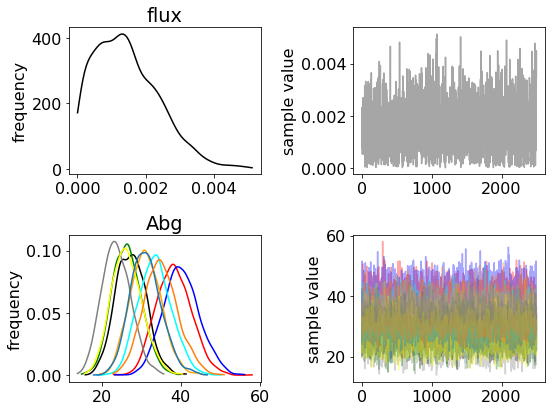

In [34]:
op3.plot(['flux','Abg']);
plt.tight_layout()

<h5>Model posterior (all data points)</h5>

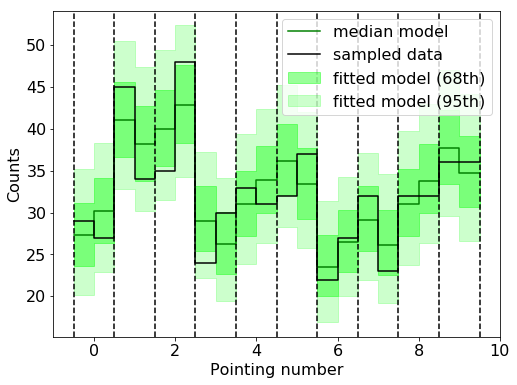

In [35]:
plt.step(pp,np.percentile(op3['model_values'],50,axis=0),color='green',where='mid',label='median model')
plt.fill_between(pp,
         np.percentile(op3['model_values'],50-68.3/2,axis=0),
         np.percentile(op3['model_values'],50+68.3/2,axis=0),step='mid',color='lime',alpha=0.4,label='fitted model (68th)')
plt.fill_between(pp,
         np.percentile(op3['model_values'],50-95.4/2,axis=0),
         np.percentile(op3['model_values'],50+95.4/2,axis=0),step='mid',color='lime',alpha=0.2,label='fitted model (95th)')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC (all data points)</h5>

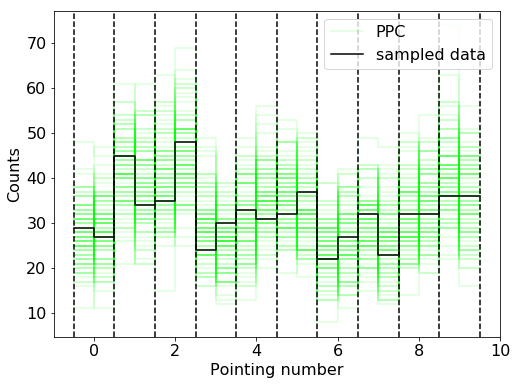

In [36]:
for i in range(0,2500,25):
    plt.step(pp,op3['ppc'][i,:],
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(pp,op3['ppc'][i,:],alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC (time)</h5>

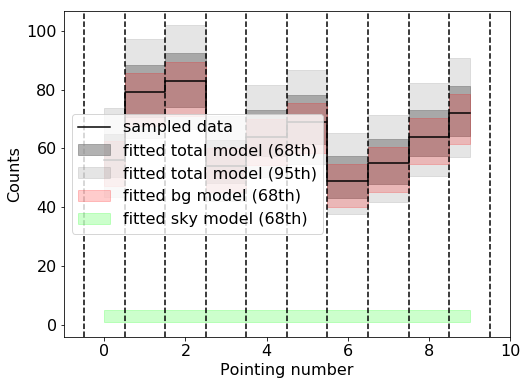

In [37]:
plt.fill_between(p,
         np.percentile(op3['model_tot'],50-68.3/2,axis=0),
         np.percentile(op3['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op3['model_tot'],50-95.4/2,axis=0),
         np.percentile(op3['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op3['model_bg'],50-68.3/2,axis=0),
         np.percentile(op3['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op3['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op3['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=6)

<h5>Did we overfit? How do we check that? What is optimal?</h5>

<h5>Let's define possible background time nodes (cuts), i.e. every 10, 5, 3, 2, 1 pointings:</h5>

In [38]:
all_cuts = [list(range(1,Np+1,int(Np/i))) for i in list(range(1,Np+1))]
all_cuts_unique = np.unique(all_cuts)

all_cuts_unique

array([list([1]), list([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
       list([1, 3, 5, 7, 9]), list([1, 4, 7, 10]), list([1, 6])],
      dtype=object)

<h5>Here, we define the figure of merit "Cash statistic" (Cash 1979), i.e. the log-Poisson likelihood.<br>
    In addition, we define the Akaike Information Criterion (Akaike 1974) that penalises too many fitted parameters in a fit:</h5>

In [39]:
def AIC(n_par, lnlik):
    return (2*n_par) - (2*lnlik)

def cashstat(data,model):
    return -2*np.sum(data*np.log(model)-model-(data*np.nan_to_num(np.log(data))-data))

<h5>Now we loop over all chosen background settings and record/calculate the cash stat (note: no sampling needed, the optimum point is enough):</h5>

In [40]:
cstat_arr = []
for c in range(len(all_cuts_unique)):
    bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts_unique[c],Np)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                  Np = Np,
                  Nsky = 1,
                  Ncuts = Ncuts,
                  bg_cuts = bg_cuts,
                  bg_idx_arr = idx_arr,
                  y = yp.ravel().astype(int),
                  bg_model = R_BG(p),
                  conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
                  mu_flux = mu_flux_scl,
                  sigma_flux = sigma_flux_scl,
                  mu_Abg = mu_Abg,
                  sigma_Abg = sigma_Abg)
    
    init = {}
    init['Abg'] = np.repeat(1,Ncuts)
    init['flux'] = np.array([1e-3])
    op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
    cstat_arr.append(cashstat(yp.ravel(),op_tmp['par']['model_values']))
cstat_arr = np.array(cstat_arr)

<h5>Number of fitted parameters (note: also the sky model scaling counts):</h5>

In [41]:
n_par_arr = np.zeros(len(all_cuts_unique))
for c in range(len(all_cuts_unique)):
    _, _, n_par_arr[c] = make_bg_cuts(all_cuts_unique[c],Np)
n_par_arr += 1

<h5>Sort array to get monotonic function (not required but can make visualisation easier):</h5>

In [42]:
so = np.argsort(n_par_arr)
n_par_arr = n_par_arr[so]

Text(0, 0.5, 'AIC')

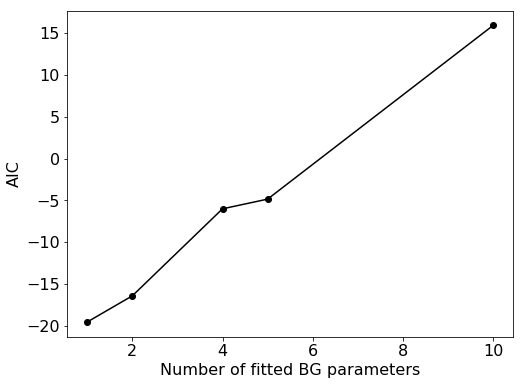

In [43]:
plt.plot(n_par_arr-1,AIC(n_par_arr,cstat_arr[so]/2),'o-')
plt.xlabel('Number of fitted BG parameters')
plt.ylabel('AIC')

<h5>???<br>
    The absolute value of the AIC has (nearly) no meaning, only the relative values:<br>
    The lowest AIC is, among the tested scenarios, indicating the most probable model.<br>
    Here, this is the configuration with only one background scaling parameters.<br>
    This is expected as we included a constant background model, so, everything works as expected.</h5>

<h3>Now, if we don't know the BG response but only the SKY response (from simulation, or ground measurements), can we extract the same information from the data themselves?</h3>

<h5>Sum data set over all times/pointings and create a background response (expected number of counts in data space bins, relative to each other, normalised to a common value, here number of detectors):</h5>

In [44]:
def R_BG_from_data(y,norm,p):
    return np.repeat(np.sum(y,axis=0)/np.sum(y)*norm,len(p)).reshape(2,len(p)).T

In [45]:
R_BG_from_data(yp,2,p)[0,:],R_BG(p)[0,:]

(array([0.99224806, 1.00775194]), array([1., 1.]))

(0, 2)

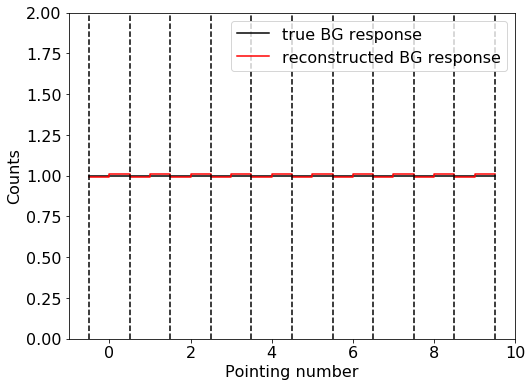

In [46]:
SPIl_plot(p,R_BG(p),color='black',label='true BG response',
          y2=R_BG_from_data(yp,2,p),color2='red',label2='reconstructed BG response')
plt.ylim(0,2)

<h5>As you can see, the sky signal smears out, and the resulting BG response is nearly identical to what we would put in in the first place.<br>
    Now running through the fits and comparing results:</h5>

In [47]:
# the only thing that is changed here is the background response, now being calculate from the data
# the rest stays the same
Np, Nrsp = R_BG_from_data(yp,2,p).shape         # initialise sizes of arrays
N = Np*Nrsp                                     # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1],Np)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(0,10,1)+1),Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG_from_data(yp,2,p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [48]:
op4 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True,pars=['flux','Abg'])

In [49]:
print(op4)

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 1.6e-3  3.9e-5 1.0e-3 8.6e-5 7.9e-4 1.5e-3 2.2e-3 3.8e-3    677    1.0
Abg[1]   30.76    0.06   1.61  27.49  29.71  30.79  31.83  33.85    670    1.0
lp__    1591.1    0.05   1.19 1587.7 1590.6 1591.4 1591.9 1592.3    525    1.0

Samples were drawn using NUTS at Sat Jul  4 15:20:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


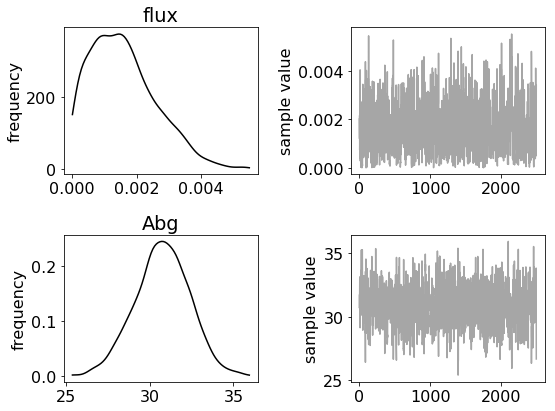

In [50]:
op4.plot()
plt.tight_layout()

In [51]:
print('True BG response results: \nflux = %2.2f+-%2.2f; Abg = %2.2f+-%2.2f' %
      (np.mean(op2['flux'])*1e3,np.std(op2['flux'])*1e3,
      np.mean(op2['Abg']),np.std(op2['Abg'])))

True BG response results: 
flux = 1.52+-0.99; Abg = 30.82+-1.56


In [52]:
print('Constructed BG response results: \nflux = %2.2f+-%2.2f; Abg = %2.2f+-%2.2f' %
      (np.mean(op4['flux'])*1e3,np.std(op4['flux'])*1e3,
      np.mean(op4['Abg']),np.std(op4['Abg'])))

Constructed BG response results: 
flux = 1.58+-1.02; Abg = 30.76+-1.61


In [53]:
print('True values: \nflux = %2.2f; Abg = %2.2f' %
      (true_sky*1e3,true_bg))

True values: 
flux = 1.00; Abg = 30.00


<h5>We will run this more than onc to see how our 'signal-to-noise-ratio' increases with increasing observation time (number of pointings):</h5>

In [54]:
n_arr = np.array([1,3,5,10,30,50,100,300,500,1000,3000,5000])

<h5>Number of tested data sets:</h5>

In [55]:
n_test = len(n_arr)

<h5>Empty arrays to save our fluxes and uncertainties in:</h5>

In [56]:
fitted_fluxes = np.zeros(n_test)
fitted_fluxes_err = np.zeros(n_test)

<h5>Loop over increasing number of pointings in data set:</h5>

In [57]:
for n in range(n_test):

    Np = n_arr[n]
    p = np.arange(Np)
    
    true_sky = 1e-3
    true_bg = 30.

    y_true = true_sky*R_SKY(p) + true_bg*R_BG(p)
    yp = np.random.poisson(y_true)
    
    Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
    N = Np*Nrsp                      # total number of data points

    mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
    # this has to be an array because it could be more than one
    sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
    mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
    sigma_Abg = 30.                  # same


    # background cuts (here only one parameter for all times)
    bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                  Np = Np,
                  Nsky = 1,
                  Ncuts = Ncuts,
                  bg_cuts = bg_cuts,
                  bg_idx_arr = idx_arr,
                  y = yp.ravel().astype(int),
                  bg_model = R_BG(p),
                  conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
                  mu_flux = mu_flux_scl,
                  sigma_flux = sigma_flux_scl,
                  mu_Abg = mu_Abg,
                  sigma_Abg = sigma_Abg)
    
    op2 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True,pars=['flux','Abg'])
    
    fitted_fluxes[n] = np.mean(op2['flux'])
    fitted_fluxes_err[n] = np.std(op2['flux'])

<h5>This can take a while since we are fitting a lot of data points (still nowhere near the real SPI data</h5>

<h5>Plot our results:</h5>

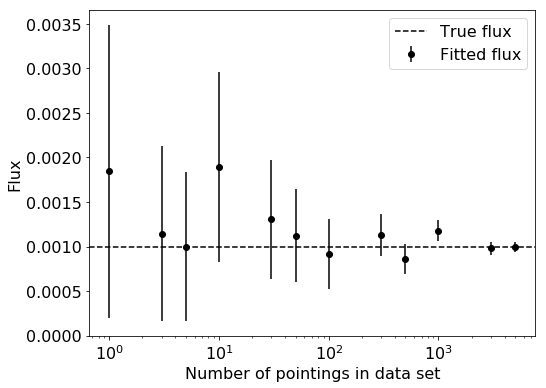

In [58]:
plt.errorbar(n_arr,fitted_fluxes,yerr=fitted_fluxes_err,marker='o',linestyle='',label='Fitted flux')
plt.xscale('log')
plt.axhline(1e-3,linestyle='--',label='True flux')
plt.xlabel('Number of pointings in data set')
plt.ylabel('Flux')
plt.legend()

<h5>Finally, signal-to-noise ratio, plus (approximation of) expected increase:</h5>

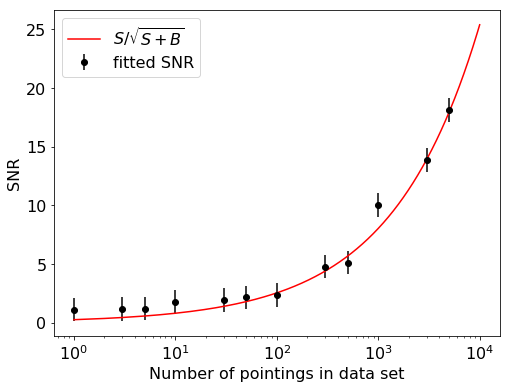

In [59]:
plt.errorbar(n_arr,fitted_fluxes/fitted_fluxes_err,
             marker='o',linestyle='',yerr=np.repeat(1,len(n_arr)),label='fitted SNR')
nn = np.arange(1,10000)
plt.plot(nn,np.sqrt(nn)*2/np.sqrt(62),label=r'$S/\sqrt{S+B}$')
plt.xscale('log')
#plt.xlim(500,5000)
plt.xlabel('Number of pointings in data set')
plt.ylabel('SNR')
plt.legend()

In [60]:
model.show()

StanModel object 'anon_model_c2e0aba85727555652db8ac183ad91d8' coded as follows:
data {

// this is the input data that is given from python to stan via a dictionary
    
    int<lower=0> N;           // number of response matrix points (data space bins = number of detectors) times number of pointings in data set
    int<lower=0> Np;          // number of pointings in observation data set
    int<lower=0> y[Np*N];     // y observations = counts in each data space bin (data)
    int<lower=1> Nsky;        // number of sky models (at least one model to be fitted; note these are already convolved)

    real bg_model[Np,N];      // BG model (response) for each pointing and detector (any tracer already applied; renormalisation fitted; time nodes fixed below)
    real conv_sky[Nsky,Np,N]; // SKY model(s) (already convolved)
  
    // background re-normalisation times
    int<lower=0> Ncuts;       // number of time nodes where/when the background is rescaled
    int bg_cuts[Np];          // tr